<p align="center">Pakistan Inflation Analysis and Modeling:</p>

**Setup:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import statistics
from datetime import datetime
import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)
# Set plot style
plt.style.use('ggplot')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
my_palette = sns.color_palette("viridis", 7)

## *PART 1: DATA PREPARATION AND EXPLORATORY ANALYSIS*

In [ ]:
data = pd.read_csv("data/Inflation_Dataset_v2.csv")

# Rename variables for easier reference
data.columns = ["Country", "Year", "Inflation", "MoneyGrowth", "FoodImports",
                "GDPgrowth", "ExchangeRate", "CrudeOil"]

# Convert Year to numeric and arrange data chronologically
data['Year'] = data['Year'].astype(int)
data = data.sort_values(by='Year')

# Display basic information about the dataset
print("Dataset Overview:")
print(data.info())
print(f"Time Period: {data['Year'].min()} to {data['Year'].max()}")
print(f"Number of observations: {len(data)}")

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       44 non-null     object 
 1   Year          44 non-null     int64  
 2   Inflation     44 non-null     float64
 3   MoneyGrowth   44 non-null     float64
 4   FoodImports   44 non-null     float64
 5   GDPgrowth     44 non-null     float64
 6   ExchangeRate  44 non-null     float64
 7   CrudeOil      44 non-null     float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.9+ KB
None
Time Period: 1980 to 2023
Number of observations: 44


## *PART 2: DESCRIPTIVE STATISTICS*

In [3]:
# Detailed summary statistics
summary_stats = data.describe()
print("\nSummary Statistics:")
print(summary_stats)



Summary Statistics:
              Year  Inflation  MoneyGrowth  FoodImports  GDPgrowth  \
count    44.000000  44.000000    44.000000    44.000000  44.000000   
mean   2001.500000   8.973356    14.919281    13.615047   4.660304   
std      12.845233   5.255009     6.581934     2.724205   2.312443   
min    1980.000000   2.529328     4.314225     8.863542  -1.274087   
25%    1990.750000   5.480644    11.538955    11.789580   3.361309   
50%    2001.500000   8.379511    14.656185    13.127080   4.618347   
75%    2012.250000  11.479437    17.611655    15.160639   6.467729   
max    2023.000000  30.768128    42.908874    20.285085  10.215704   

       ExchangeRate    CrudeOil  
count     44.000000   44.000000  
mean      67.418472   49.805227  
std       57.255468   25.923587  
min        9.900000   15.480000  
25%       23.277419   24.070000  
50%       58.004930   47.295000  
75%       95.321420   65.735000  
max      280.356112  101.570000  


In [4]:
# Create a comprehensive summary table
def get_mode(series):
    return statistics.mode(series) if len(series) > 0 else None
vars_to_analyze = ["Inflation", "MoneyGrowth", "FoodImports",
                  "GDPgrowth", "ExchangeRate", "CrudeOil"]
summary_table = pd.DataFrame({
    'Variable': vars_to_analyze,
    'Mean': [data[var].mean() for var in vars_to_analyze],
    'Median': [data[var].median() for var in vars_to_analyze],
    'Mode': [data[var].mode()[0] for var in vars_to_analyze],
    'SD': [data[var].std() for var in vars_to_analyze],
    'Min': [data[var].min() for var in vars_to_analyze],
    'Q1': [data[var].quantile(0.25) for var in vars_to_analyze],
    'Q3': [data[var].quantile(0.75) for var in vars_to_analyze],
    'Max': [data[var].max() for var in vars_to_analyze],
    'CV': [data[var].std() / data[var].mean() * 100 for var in vars_to_analyze]  # Coefficient of variation
})
# Print formatted table
print("\nSummary Statistics for Key Variables:")
print(summary_table.round(2))


Summary Statistics for Key Variables:
       Variable   Mean  Median   Mode     SD    Min     Q1     Q3     Max  \
0     Inflation   8.97    8.38   2.53   5.26   2.53   5.48  11.48   30.77   
1   MoneyGrowth  14.92   14.66   4.31   6.58   4.31  11.54  17.61   42.91   
2   FoodImports  13.62   13.13   8.86   2.72   8.86  11.79  15.16   20.29   
3     GDPgrowth   4.66    4.62  -1.27   2.31  -1.27   3.36   6.47   10.22   
4  ExchangeRate  67.42   58.00   9.90  57.26   9.90  23.28  95.32  280.36   
5      CrudeOil  49.81   47.30  15.48  25.92  15.48  24.07  65.74  101.57   

      CV  
0  58.56  
1  44.12  
2  20.01  
3  49.62  
4  84.93  
5  52.05  


## *PART 3: DATA VISUALIZATION*

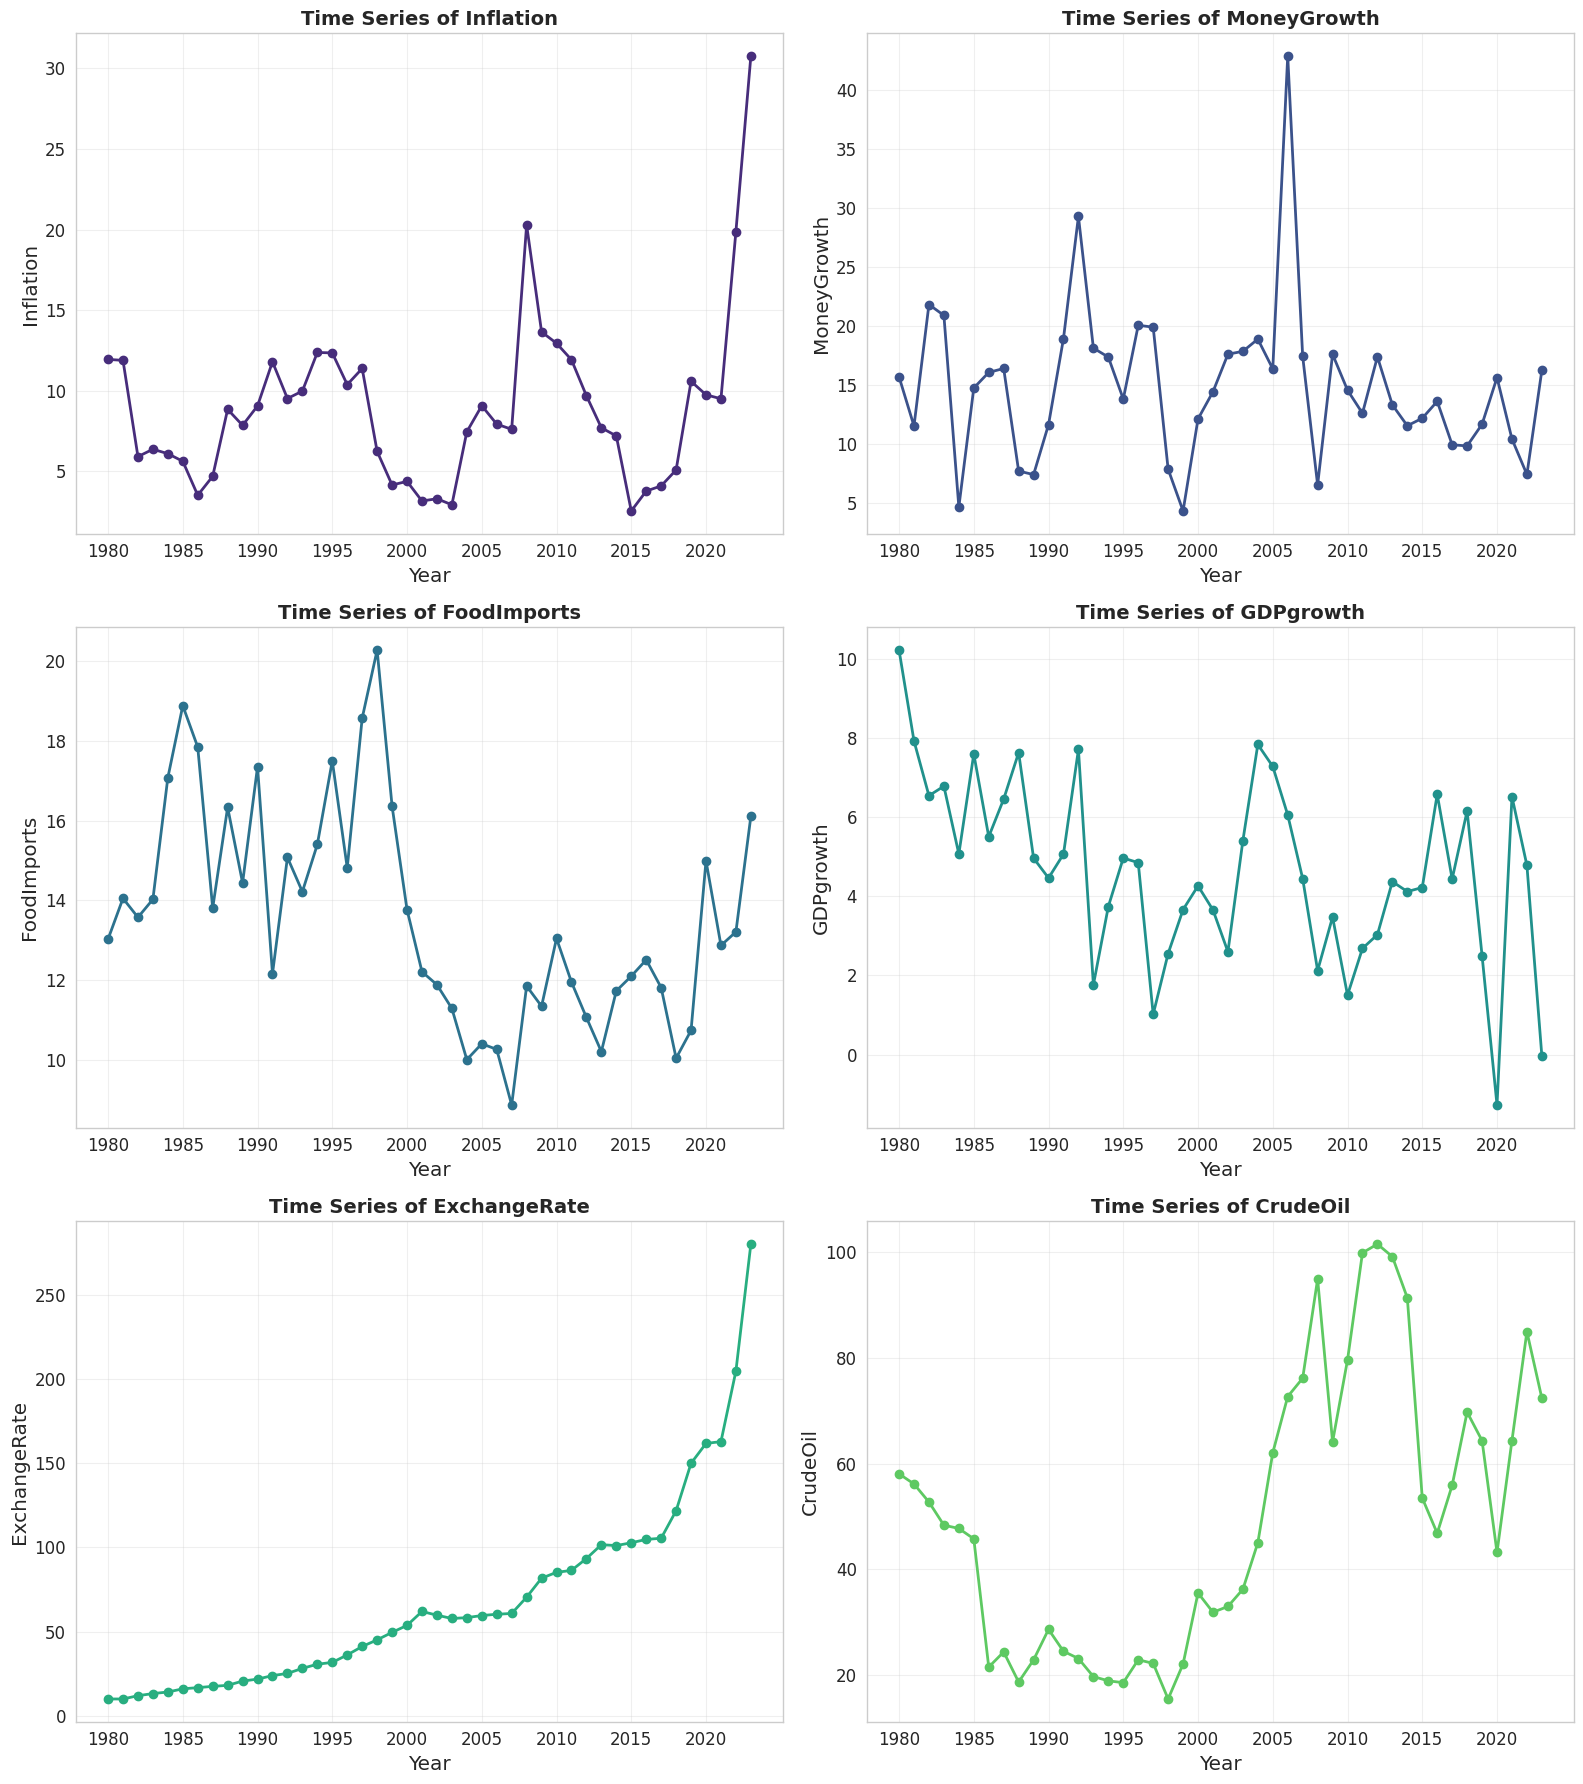

In [5]:
# Time series plots for all variables
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

for i, var in enumerate(vars_to_analyze):
    axes[i].plot(data['Year'], data[var], marker='o', color=my_palette[i], linewidth=2)
    axes[i].set_title(f'Time Series of {var}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel(var)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xticks(range(data['Year'].min(), data['Year'].max()+1, 5))

plt.tight_layout()
plt.savefig('time_series_plots.png', dpi=300)
plt.show()


Outliers in each variable:

Outliers in Inflation:
    Year  Inflation
43  2023  30.768128

Outliers in MoneyGrowth:
    Year  MoneyGrowth
12  1992    29.300563
26  2006    42.908874

Outliers in FoodImports:
    Year  FoodImports
18  1998    20.285085

Outliers in ExchangeRate:
    Year  ExchangeRate
42  2022    204.867188
43  2023    280.356112


<ipython-input-6-14af5c7c84f1>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Variable', y='Value', data=boxplot_data, palette='viridis', showfliers=False)
<ipython-input-6-14af5c7c84f1>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='Variable', y='Value', data=boxplot_data, size=4, alpha=0.5, jitter=True, palette='viridis')


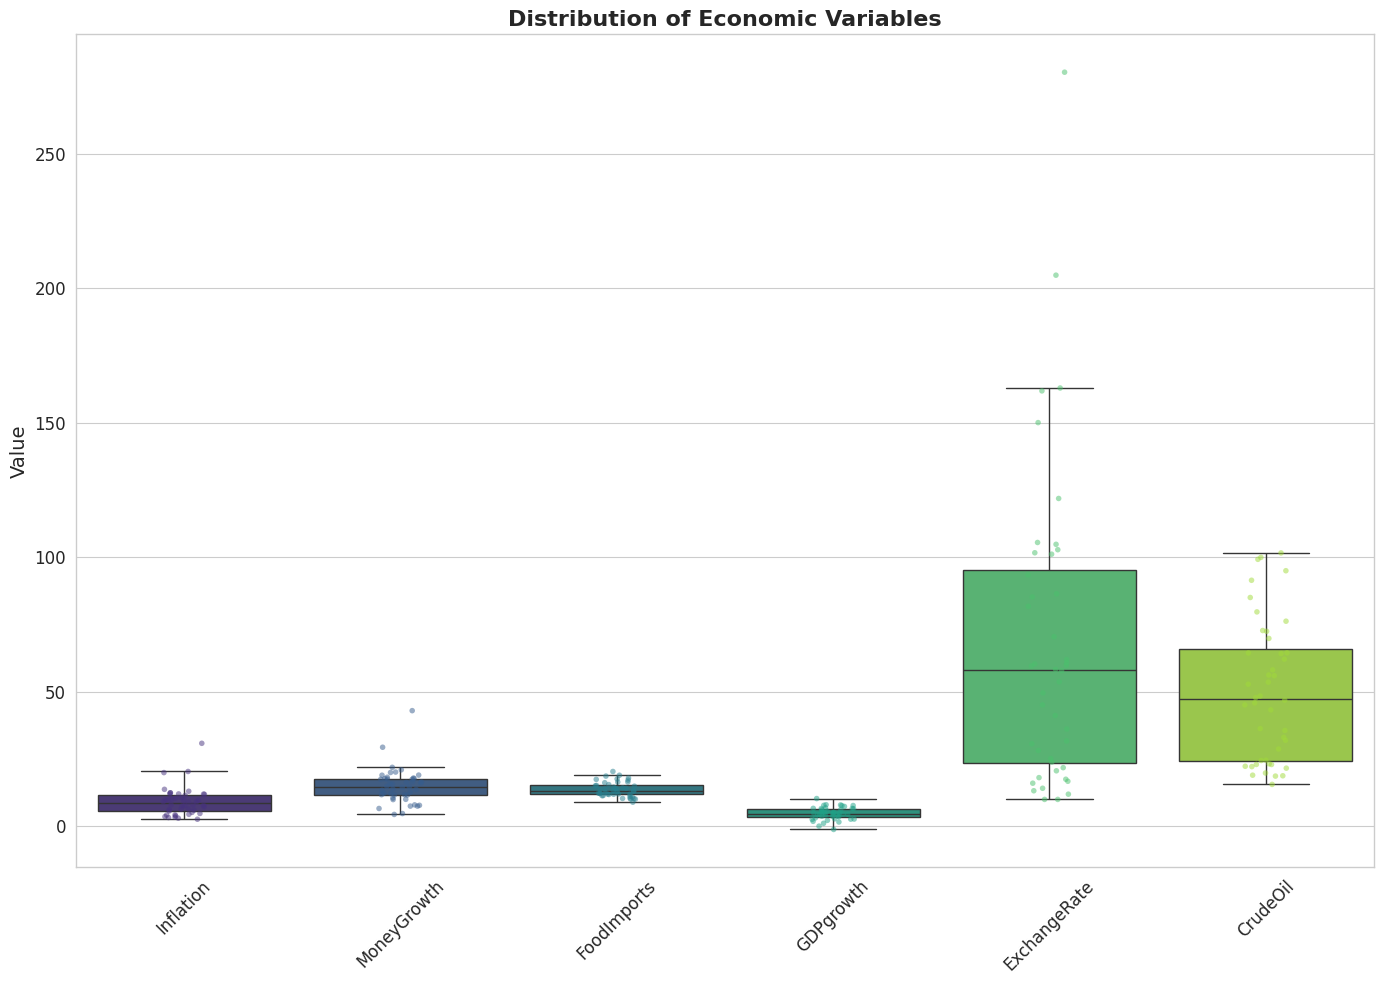

In [6]:
# Calculate outliers using IQR
def get_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Identify outliers for each variable
print("\nOutliers in each variable:")
for var in vars_to_analyze:
    outliers = get_outliers(data, var)
    if not outliers.empty:
        print(f"\nOutliers in {var}:")
        print(outliers[['Year', var]])

# Enhanced boxplots with jittered points for outlier detection
plt.figure(figsize=(14, 10))
boxplot_data = pd.melt(data, id_vars=['Country', 'Year'], value_vars=vars_to_analyze,
                      var_name='Variable', value_name='Value')

sns.boxplot(x='Variable', y='Value', data=boxplot_data, palette='viridis', showfliers=False)
sns.stripplot(x='Variable', y='Value', data=boxplot_data, size=4, alpha=0.5, jitter=True, palette='viridis')

plt.title('Distribution of Economic Variables', fontsize=16, fontweight='bold')
plt.xlabel('')
plt.ylabel('Value', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('boxplots.png', dpi=300)
plt.show()

*Correlation analysis:*


Correlation Matrix:
              Inflation  MoneyGrowth  FoodImports  GDPgrowth  ExchangeRate  \
Inflation          1.00        -0.02         0.07      -0.33          0.49   
MoneyGrowth       -0.02         1.00        -0.21       0.14         -0.16   
FoodImports        0.07        -0.21         1.00      -0.11         -0.28   
GDPgrowth         -0.33         0.14        -0.11       1.00         -0.47   
ExchangeRate       0.49        -0.16        -0.28      -0.47          1.00   
CrudeOil           0.34        -0.04        -0.61      -0.12          0.53   

              CrudeOil  
Inflation         0.34  
MoneyGrowth      -0.04  
FoodImports      -0.61  
GDPgrowth        -0.12  
ExchangeRate      0.53  
CrudeOil          1.00  


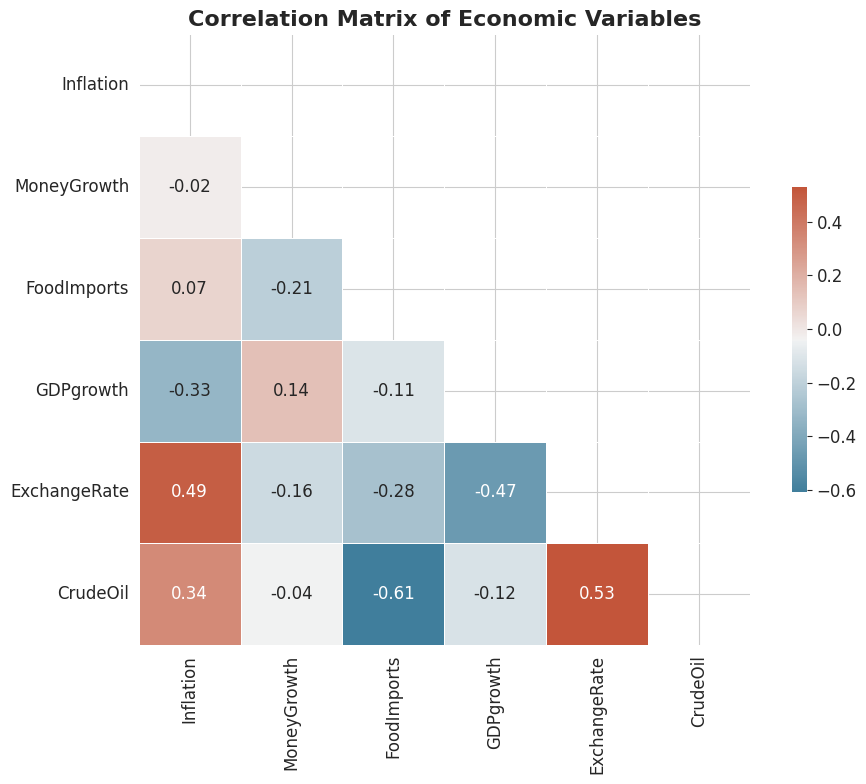

In [7]:
# Compute the correlation matrix
corr_matrix = data[vars_to_analyze].corr()
print("\nCorrelation Matrix:")
print(corr_matrix.round(2))
# Heatmap of correlation matrix
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap, mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix of Economic Variables', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300)
plt.show()

*Scatter plot matrix of variables against Inflation:*

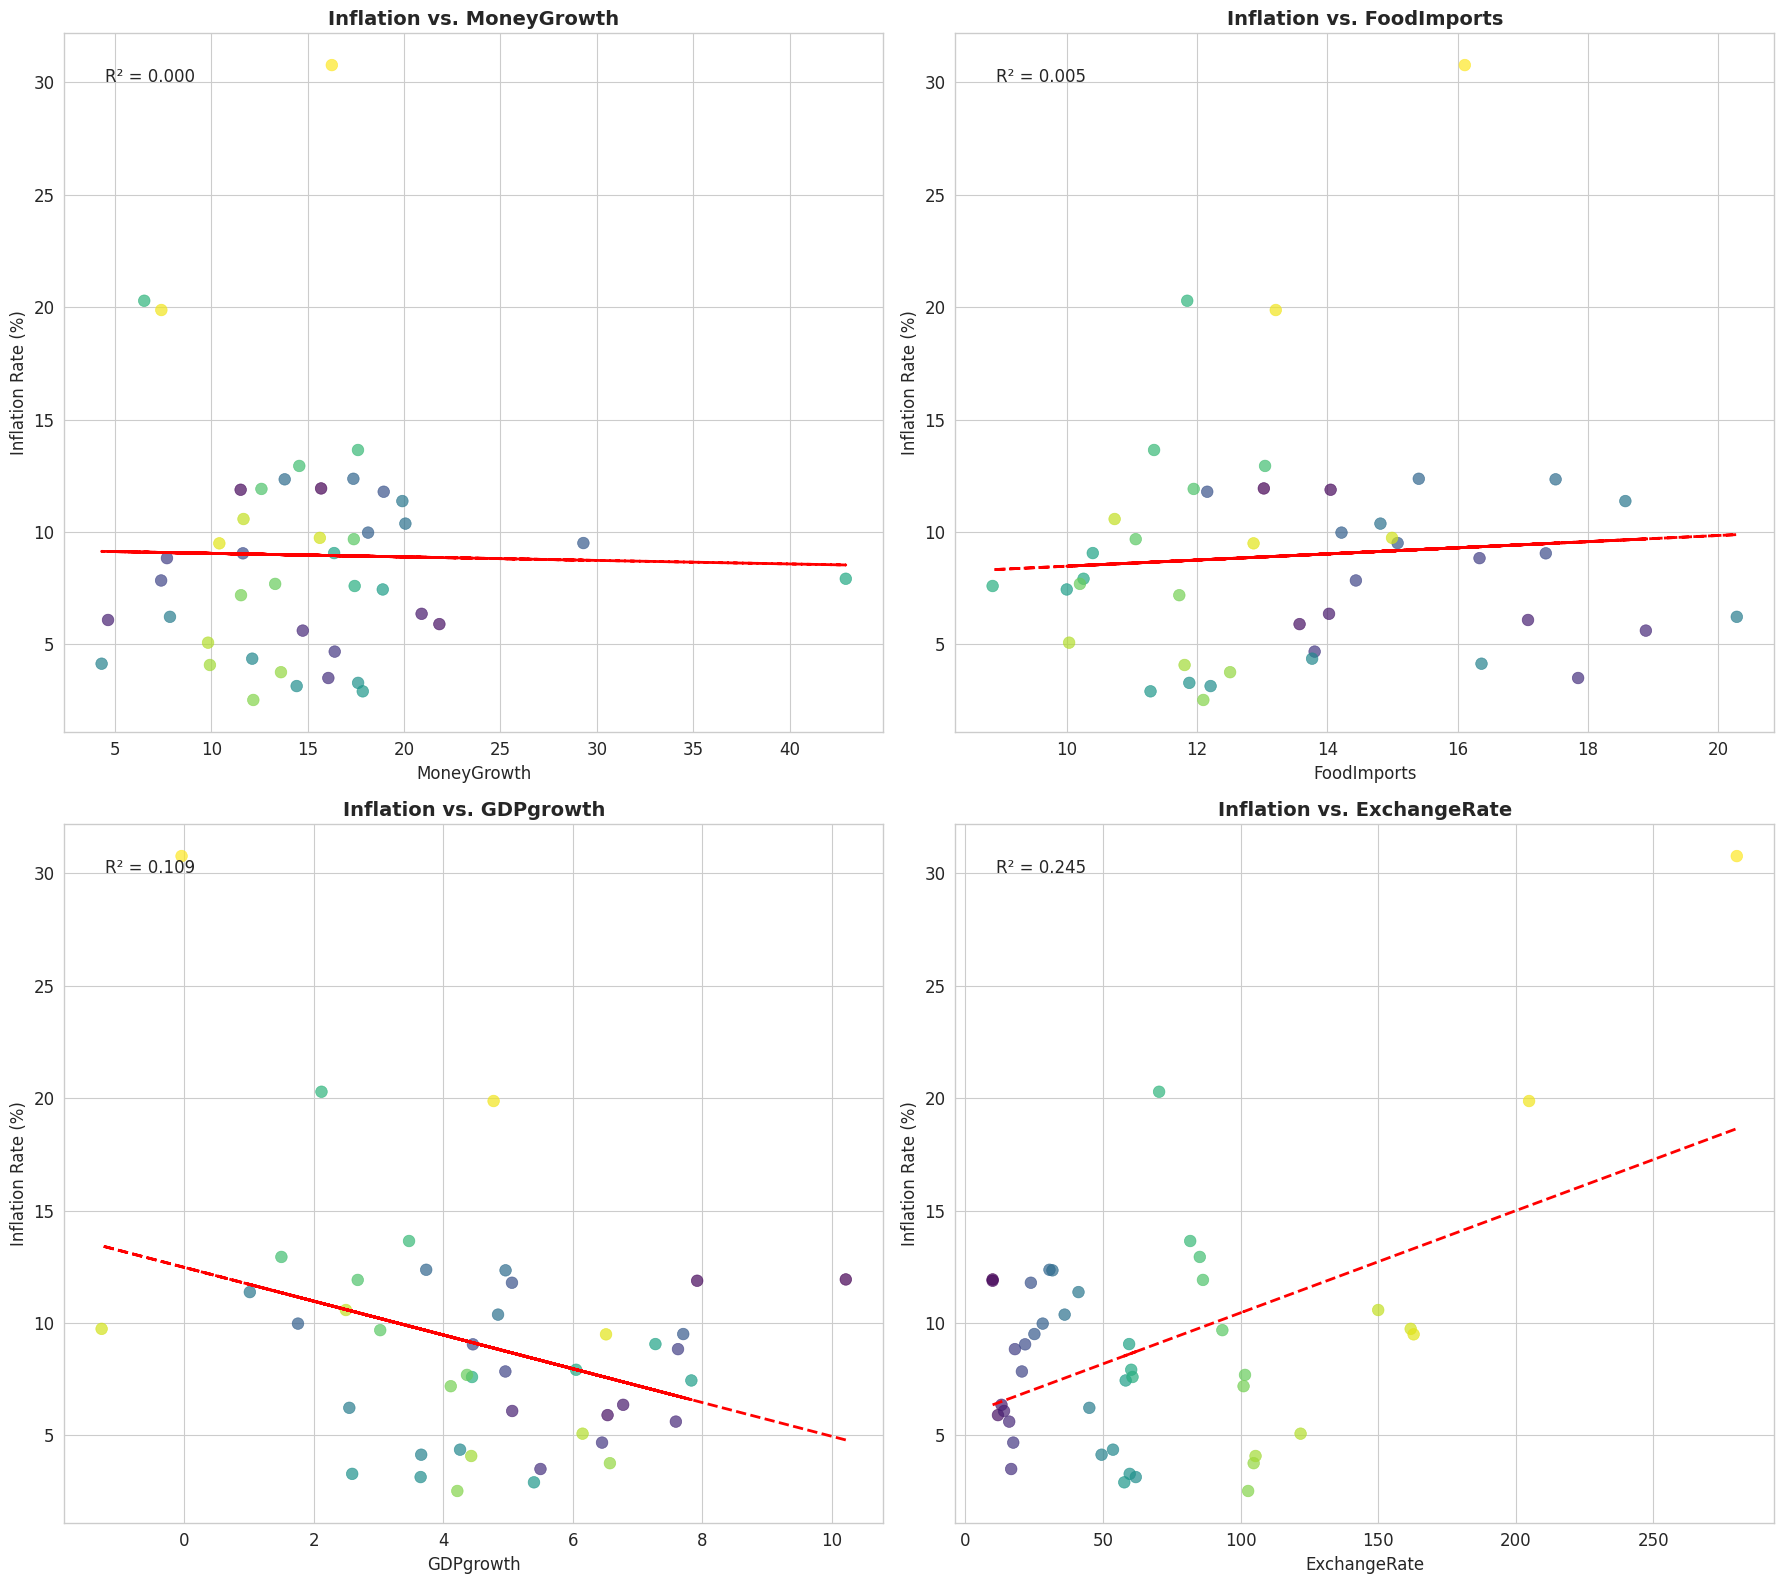

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
axes = axes.flatten()

for i, var in enumerate(vars_to_analyze[1:5]):  # Exclude Inflation itself
    axes[i].scatter(data[var], data['Inflation'], c=data['Year'], cmap='viridis', s=70, alpha=0.7)
    axes[i].set_title(f'Inflation vs. {var}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(var, fontsize=12)
    axes[i].set_ylabel('Inflation Rate (%)', fontsize=12)

    # Add regression line
    x = data[var]
    y = data['Inflation']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    axes[i].plot(x, p(x), "r--", linewidth=2)

    # Add R-squared value
    correlation = np.corrcoef(x, y)[0, 1]
    r_squared = correlation**2
    axes[i].text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=axes[i].transAxes,
                fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.savefig('scatter_plots.png', dpi=300)
plt.show()

# **DATA PREPARATION FOR MODELING**

In [9]:
# Check for stationarity
def check_stationarity(series, window=12):
    # Perform Dickey-Fuller test
    result = adfuller(series.dropna())

    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value:.4f}')

    if result[1] <= 0.05:
        print("Series is stationary")
        return True
    else:
        print("Series is not stationary")
        return False

print("\nChecking stationarity of Inflation:")
is_stationary = check_stationarity(data['Inflation'])

# Function to create differenced series if needed
def difference_series(series):
    return series.diff().dropna()
# Use the first 80% for training and the last 20% for testing
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

print(f"\nTraining data: {len(train_data)} rows ({train_data['Year'].min()} to {train_data['Year'].max()})")
print(f"Testing data: {len(test_data)} rows ({test_data['Year'].min()} to {test_data['Year'].max()})")
# Prepare data for ARIMA
train_ts = train_data['Inflation'].values
test_ts = test_data['Inflation'].values
# Prepare data for regression models
X_train = train_data[['MoneyGrowth', 'FoodImports', 'GDPgrowth', 'ExchangeRate', 'CrudeOil']]
y_train = train_data['Inflation']
X_test = test_data[['MoneyGrowth', 'FoodImports', 'GDPgrowth', 'ExchangeRate', 'CrudeOil']]
y_test = test_data['Inflation']
# Standardize features for regression models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Checking stationarity of Inflation:
ADF Statistic: -3.2327
p-value: 0.0182
Critical Value (1%): -3.6209
Critical Value (5%): -2.9435
Critical Value (10%): -2.6104
Series is stationary

Training data: 35 rows (1980 to 2014)
Testing data: 9 rows (2015 to 2023)


# **MODEL 1: ARIMA**

In [10]:
print("\nFitting ARIMA model...")

# Define candidate orders for exhaustive AIC comparison
orders = [(2,0,2), (0,0,0), (1,0,0), (0,0,1), (0,0,0), (2,0,0), (1,0,1), (2,0,1), (1,0,0)]
mean_flags = [True, True, True, True, False, True, True, True, False]
labels = ["ARIMA(2,0,2)", "ARIMA(0,0,0)", "ARIMA(1,0,0)", "ARIMA(0,0,1)",
          "ARIMA(0,0,0)", "ARIMA(2,0,0)", "ARIMA(1,0,1)", "ARIMA(2,0,1)", "ARIMA(1,0,0)"]

# Fit each model and collect AIC
aic_table = pd.DataFrame(columns=['Model', 'Mean', 'AIC'])

for i, (order, include_mean, label) in enumerate(zip(orders, mean_flags, labels)):
    try:
        # Convert include_mean to 'c' for constant/intercept in ARIMA
        trend = 'c' if include_mean else 'n'
        fit_i = ARIMA(train_ts, order=order, trend=trend).fit()
        aic_table.loc[i] = [label, "non-zero mean" if include_mean else "zero mean", round(fit_i.aic, 2)]
    except:
        aic_table.loc[i] = [label, "non-zero mean" if include_mean else "zero mean", np.nan]

print("ARIMA Model Selection Results:")
for i in range(len(aic_table)):
    print(f"• {aic_table.iloc[i]['Model']} with {aic_table.iloc[i]['Mean']}: AIC = {aic_table.iloc[i]['AIC']}")


Fitting ARIMA model...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Model Selection Results:
• ARIMA(2,0,2) with non-zero mean: AIC = 186.25
• ARIMA(0,0,0) with non-zero mean: AIC = 194.67
• ARIMA(1,0,0) with non-zero mean: AIC = 180.28
• ARIMA(0,0,1) with non-zero mean: AIC = 184.61
• ARIMA(0,0,0) with zero mean: AIC = 257.45
• ARIMA(2,0,0) with non-zero mean: AIC = 182.27
• ARIMA(1,0,1) with non-zero mean: AIC = 182.27
• ARIMA(2,0,1) with non-zero mean: AIC = 184.06
• ARIMA(1,0,0) with zero mean: AIC = 186.91


In [11]:
# Identify best (minimum AIC) and refit it
best_idx = aic_table['AIC'].idxmin()
best_order = orders[best_idx]
best_trend = 'c' if mean_flags[best_idx] else 'n'
best_label = labels[best_idx]

# Fit best ARIMA model
best_fit = ARIMA(train_ts, order=best_order, trend=best_trend).fit()

print(f"\nModel Summary ({best_label} with {'Non-Zero Mean' if mean_flags[best_idx] else 'Zero Mean'}):")
print(best_fit.summary())


Model Summary (ARIMA(1,0,0) with Non-Zero Mean):
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   35
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -87.142
Date:                Tue, 06 May 2025   AIC                            180.283
Time:                        21:59:16   BIC                            184.949
Sample:                             0   HQIC                           181.894
                                 - 35                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6240      1.578      5.465      0.000       5.531      11.717
ar.L1          0.6097      0.188      3.247      0.001       0.242       0.978
si

In [12]:
# Generate in-sample predictions
arima_pred_train = best_fit.predict(start=0, end=len(train_ts)-1)

# Generate out-of-sample predictions
arima_forecast = best_fit.forecast(steps=len(test_ts))
arima_pred_test = arima_forecast

# Calculate MSE
mse_train_arima = mean_squared_error(train_ts, arima_pred_train)
mse_test_arima = mean_squared_error(test_ts, arima_pred_test)

print(f"\nTraining Set Error Metrics:")
print(f"MSE: {mse_train_arima:.4f}")
print(f"RMSE: {np.sqrt(mse_train_arima):.4f}")
print(f"MAE: {np.mean(np.abs(train_ts - arima_pred_train)):.4f}")

print(f"\nTest Set Error Metrics:")
print(f"MSE: {mse_test_arima:.4f}")
print(f"RMSE: {np.sqrt(mse_test_arima):.4f}")
print(f"MAE: {np.mean(np.abs(test_ts - arima_pred_test)):.4f}")


Training Set Error Metrics:
MSE: 8.5178
RMSE: 2.9185
MAE: 2.0857

Test Set Error Metrics:
MSE: 77.7512
RMSE: 8.8177
MAE: 6.0808


*Plot ARIMA Results*

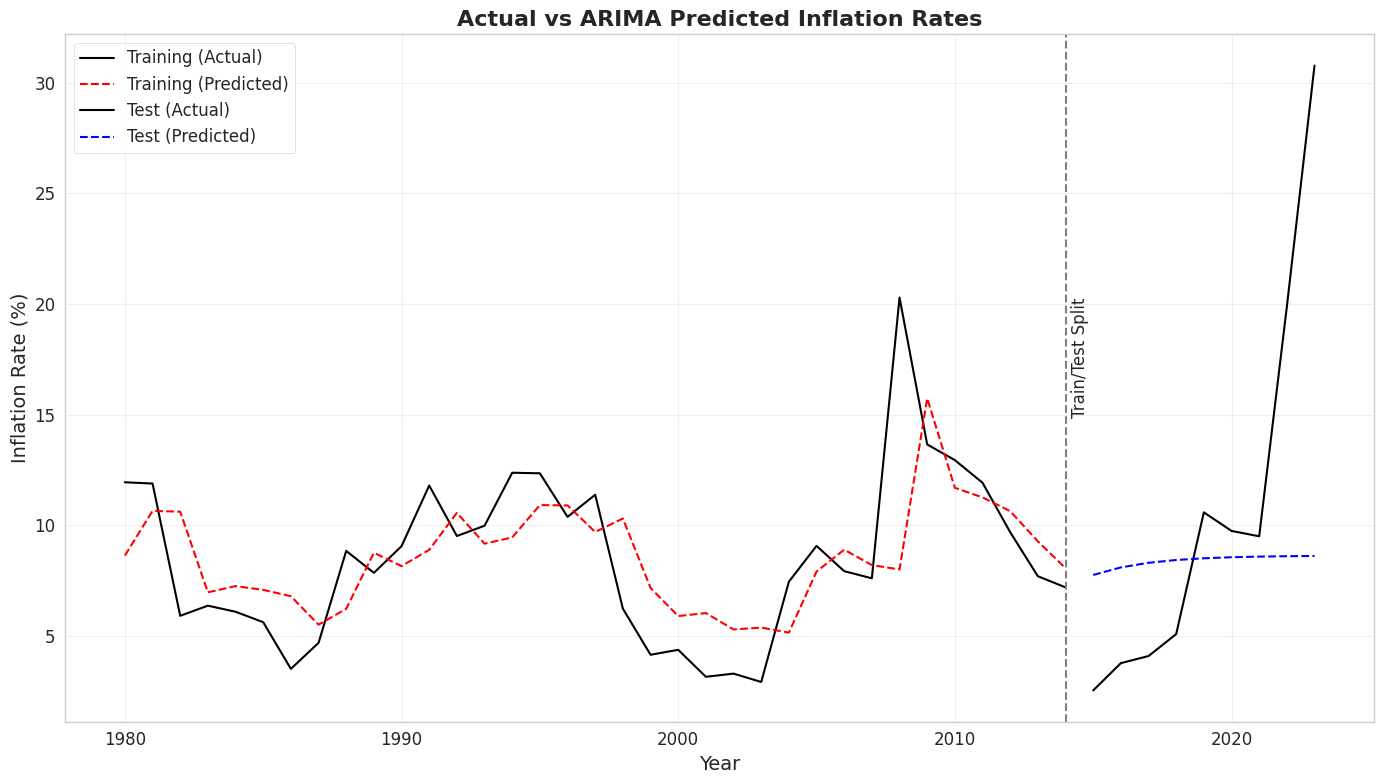

In [13]:
plt.figure(figsize=(14, 8))
plt.plot(train_data['Year'], train_ts, 'k-', label='Training (Actual)')
plt.plot(train_data['Year'], arima_pred_train, 'r--', label='Training (Predicted)')
plt.plot(test_data['Year'], test_ts, 'k-', label='Test (Actual)')
plt.plot(test_data['Year'], arima_pred_test, 'b--', label='Test (Predicted)')
plt.axvline(x=train_data['Year'].max(), color='gray', linestyle='--')
plt.text(train_data['Year'].max()+0.2, max(train_ts), 'Train/Test Split',
         rotation=90, verticalalignment='top')
plt.title('Actual vs ARIMA Predicted Inflation Rates', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Inflation Rate (%)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('arima_predictions.png', dpi=300)
plt.show()

# **MODEL 2: RIDGE REGRESSION**

In [14]:
print("\nFitting Ridge regression model...")
# Use GridSearchCV to find optimal alpha
param_grid = {'alpha': np.logspace(-3, 3, 100)}
ridge_cv = GridSearchCV(Ridge(random_state=42), param_grid, cv=5)
ridge_cv.fit(X_train_scaled, y_train)
ridge_model = ridge_cv.best_estimator_

print(f"Ridge model alpha: {ridge_cv.best_params_['alpha']}")
print("Ridge model coefficients:")
for feature, coef in zip(X_train.columns, ridge_model.coef_):
    print(f"{feature}: {coef:.4f}")


Fitting Ridge regression model...
Ridge model alpha: 1000.0
Ridge model coefficients:
MoneyGrowth: -0.0037
FoodImports: -0.0116
GDPgrowth: -0.0221
ExchangeRate: 0.0154
CrudeOil: 0.0400


In [16]:
# Generate predictions
ridge_pred_train = ridge_model.predict(X_train_scaled)
ridge_pred_test = ridge_model.predict(X_test_scaled)
# Calculate MSE
mse_train_ridge = mean_squared_error(y_train, ridge_pred_train)
mse_test_ridge = mean_squared_error(y_test, ridge_pred_test)
print(f"Ridge Train MSE: {mse_train_ridge:.4f}")
print(f"Ridge Test MSE: {mse_test_ridge:.4f}")

Ridge Train MSE: 13.4514
Ridge Test MSE: 78.6900


# **MODEL 3: LASSO REGRESSION**

In [17]:
print("\nFitting LASSO regression model...")
# Use GridSearchCV to find optimal alpha
param_grid = {'alpha': np.logspace(-3, 3, 100)}
lasso_cv = GridSearchCV(Lasso(random_state=42, max_iter=10000), param_grid, cv=5)
lasso_cv.fit(X_train_scaled, y_train)
lasso_model = lasso_cv.best_estimator_
print(f"LASSO model alpha: {lasso_cv.best_params_['alpha']}")
print("LASSO model coefficients:")
for feature, coef in zip(X_train.columns, lasso_model.coef_):
    print(f"{feature}: {coef:.4f}")


Fitting LASSO regression model...
LASSO model alpha: 1.873817422860385
LASSO model coefficients:
MoneyGrowth: -0.0000
FoodImports: -0.0000
GDPgrowth: -0.0000
ExchangeRate: 0.0000
CrudeOil: 0.0000


In [18]:
# Generate predictions
lasso_pred_train = lasso_model.predict(X_train_scaled)
lasso_pred_test = lasso_model.predict(X_test_scaled)
# Calculate MSE
mse_train_lasso = mean_squared_error(y_train, lasso_pred_train)
mse_test_lasso = mean_squared_error(y_test, lasso_pred_test)
print(f"LASSO Train MSE: {mse_train_lasso:.4f}")
print(f"LASSO Test MSE: {mse_test_lasso:.4f}")

LASSO Train MSE: 13.5972
LASSO Test MSE: 79.9775


# **MODEL 4: ELASTIC NET REGRESSION**

In [19]:
print("\nFitting Elastic Net regression model...")
# Use GridSearchCV to find optimal alpha and l1_ratio
param_grid = {
    'alpha': np.logspace(-3, 3, 20),
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
elastic_cv = GridSearchCV(ElasticNet(random_state=42, max_iter=10000), param_grid, cv=5)
elastic_cv.fit(X_train_scaled, y_train)
elastic_model = elastic_cv.best_estimator_

print(f"Elastic Net model alpha: {elastic_cv.best_params_['alpha']}")
print(f"Elastic Net model l1_ratio: {elastic_cv.best_params_['l1_ratio']}")
print("Elastic Net model coefficients:")
for feature, coef in zip(X_train.columns, elastic_model.coef_):
    print(f"{feature}: {coef:.4f}")


Fitting Elastic Net regression model...
Elastic Net model alpha: 2.976351441631316
Elastic Net model l1_ratio: 0.7
Elastic Net model coefficients:
MoneyGrowth: -0.0000
FoodImports: -0.0000
GDPgrowth: -0.0000
ExchangeRate: 0.0000
CrudeOil: 0.0000


In [20]:
# Generate predictions
elastic_pred_train = elastic_model.predict(X_train_scaled)
elastic_pred_test = elastic_model.predict(X_test_scaled)
# Calculate MSE
mse_train_elastic = mean_squared_error(y_train, elastic_pred_train)
mse_test_elastic = mean_squared_error(y_test, elastic_pred_test)
print(f"Elastic Net Train MSE: {mse_train_elastic:.4f}")
print(f"Elastic Net Test MSE: {mse_test_elastic:.4f}")

Elastic Net Train MSE: 13.5972
Elastic Net Test MSE: 79.9775


# **MODEL COMPARISON AND EVALUATION**

*Comparison Table for MSE*

In [21]:
mse_table = pd.DataFrame({
    'Model': ['ARIMA', 'Ridge', 'LASSO', 'Elastic Net'],
    'MSE_Train': [mse_train_arima, mse_train_ridge, mse_train_lasso, mse_train_elastic],
    'MSE_Test': [mse_test_arima, mse_test_ridge, mse_test_lasso, mse_test_elastic]
})
# Format MSE table
mse_table['MSE_Train'] = mse_table['MSE_Train'].round(4)
mse_table['MSE_Test'] = mse_table['MSE_Test'].round(4)
# Print MSE table
print("\nModel Performance Comparison:")
print(mse_table)


Model Performance Comparison:
         Model  MSE_Train  MSE_Test
0        ARIMA     8.5178   77.7512
1        Ridge    13.4514   78.6900
2        LASSO    13.5972   79.9775
3  Elastic Net    13.5972   79.9775


*Plot MSE Comparison*

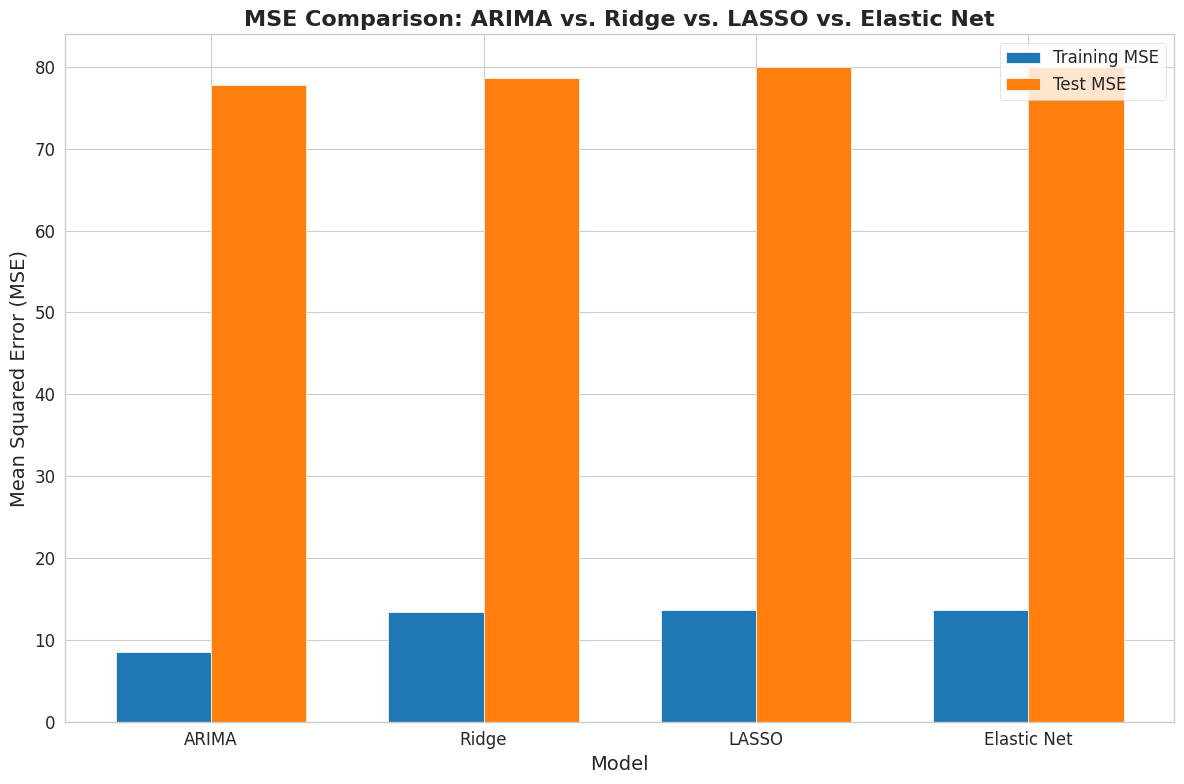

In [22]:
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(mse_table['Model']))
plt.bar(index, mse_table['MSE_Train'], bar_width, label='Training MSE', color='#1f77b4')
plt.bar(index + bar_width, mse_table['MSE_Test'], bar_width, label='Test MSE', color='#ff7f0e')
plt.xlabel('Model', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.title('MSE Comparison: ARIMA vs. Ridge vs. LASSO vs. Elastic Net', fontsize=16, fontweight='bold')
plt.xticks(index + bar_width/2, mse_table['Model'])
plt.legend()
plt.tight_layout()
plt.savefig('mse_comparison.png', dpi=300)
plt.show()

*Find best model*


Best performing model based on Test MSE: ARIMA


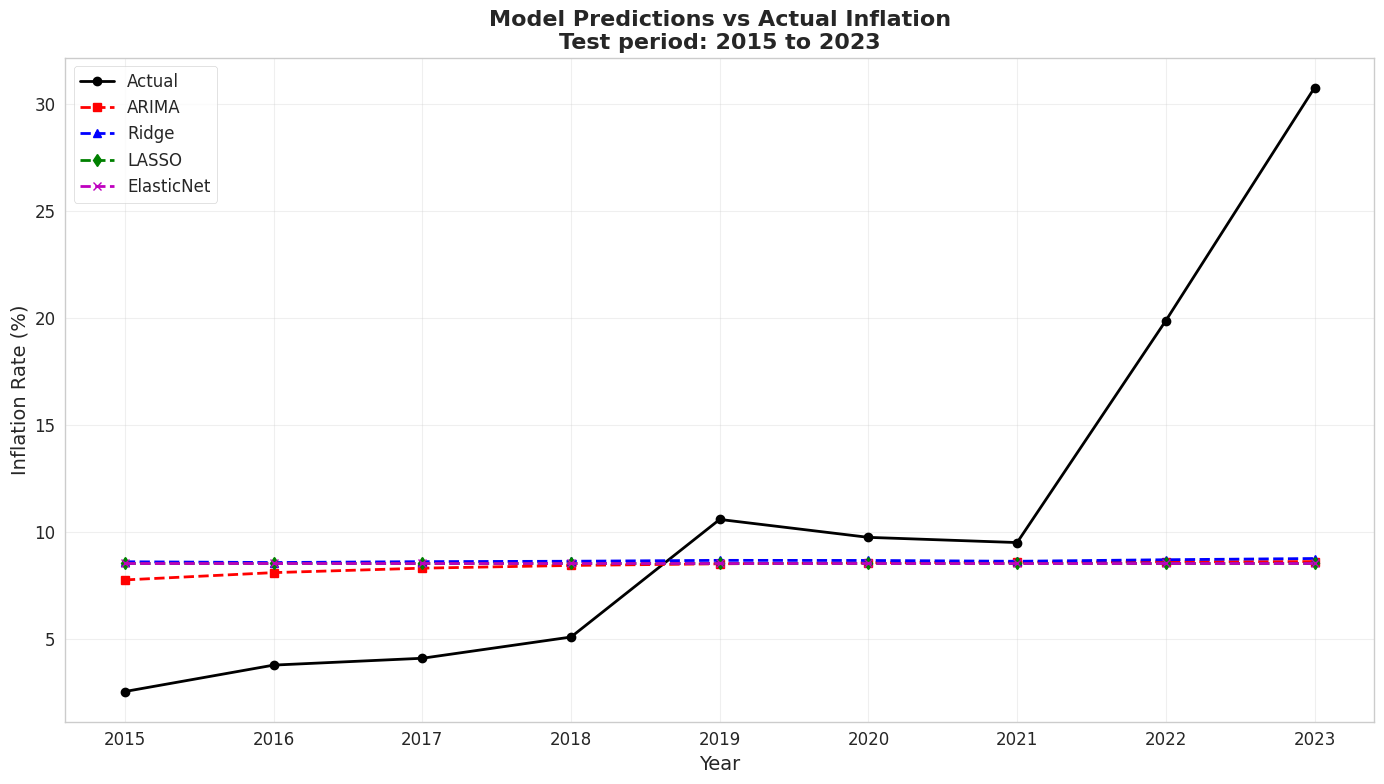

In [23]:
# Find best model
best_model = mse_table.loc[mse_table['MSE_Test'].idxmin(), 'Model']
print(f"\nBest performing model based on Test MSE: {best_model}")
# Create prediction dataset for visualization
predictions_df = pd.DataFrame({
    'Year': test_data['Year'],
    'Actual': y_test.values,
    'ARIMA': arima_pred_test,
    'Ridge': ridge_pred_test,
    'LASSO': lasso_pred_test,
    'ElasticNet': elastic_pred_test
})
# Plot model predictions comparison
plt.figure(figsize=(14, 8))
plt.plot(predictions_df['Year'], predictions_df['Actual'], 'k-', marker='o', linewidth=2, label='Actual')
plt.plot(predictions_df['Year'], predictions_df['ARIMA'], 'r--', marker='s', linewidth=2, label='ARIMA')
plt.plot(predictions_df['Year'], predictions_df['Ridge'], 'b--', marker='^', linewidth=2, label='Ridge')
plt.plot(predictions_df['Year'], predictions_df['LASSO'], 'g--', marker='d', linewidth=2, label='LASSO')
plt.plot(predictions_df['Year'], predictions_df['ElasticNet'], 'm--', marker='x', linewidth=2, label='ElasticNet')

plt.title(f'Model Predictions vs Actual Inflation\nTest period: {test_data["Year"].min()} to {test_data["Year"].max()}',
          fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Inflation Rate (%)', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('model_predictions.png', dpi=300)
plt.show()

In [24]:
# Create interactive plot with plotly
fig = px.line(predictions_df, x='Year', y=['Actual', 'ARIMA', 'Ridge', 'LASSO', 'ElasticNet'],
              title='Model Predictions vs Actual Inflation',
              labels={'value': 'Inflation Rate (%)', 'variable': 'Model'})
fig.update_layout(legend_title_text='Model')
fig.write_html('model_predictions_interactive.html')

# **VARIABLE IMPORTANCE ANALYSIS**

<ipython-input-25-8de4026b0eea>:9: RuntimeWarning:

invalid value encountered in divide



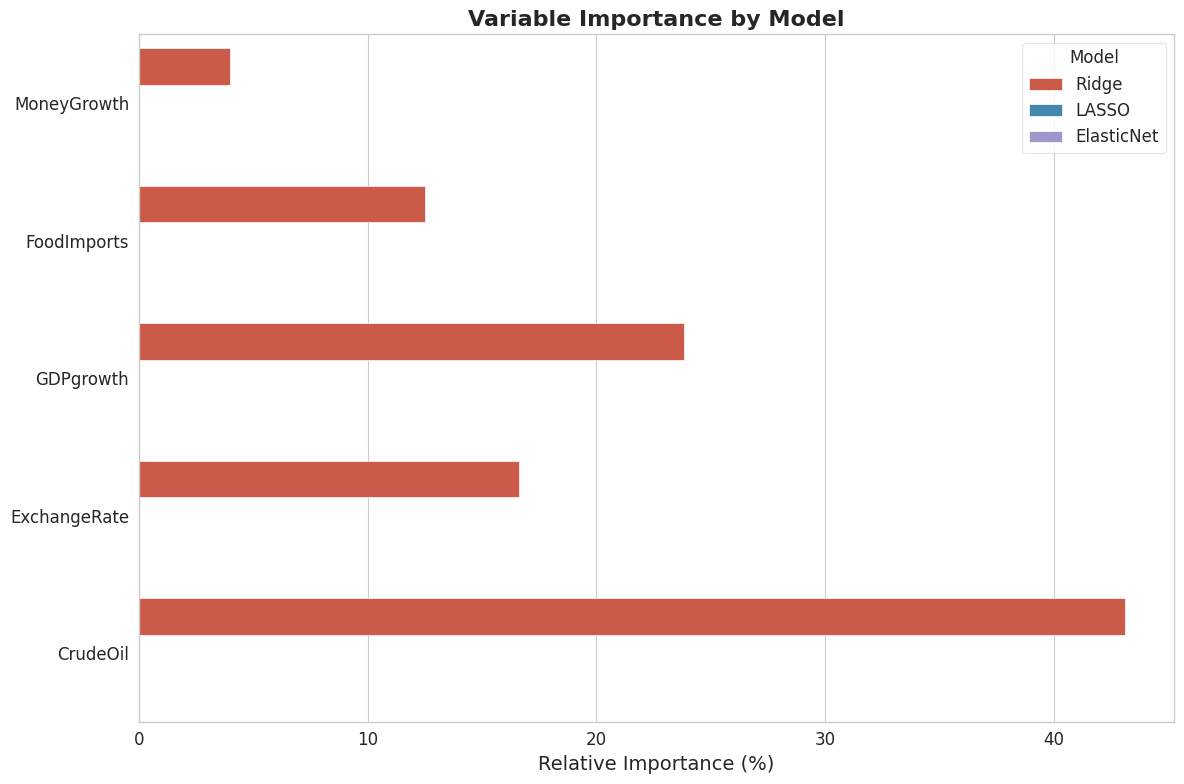

In [25]:
# Function to extract and normalize variable importance
def get_var_importance(model, model_type):
    if model_type == "ARIMA":
        return None  # ARIMA doesn't have variable importance
    else:
        # Get absolute coefficients
        coeffs = np.abs(model.coef_)
        # Normalize to sum to 100%
        importance = coeffs / np.sum(coeffs) * 100
        return importance
# Extract variable importance from models
ridge_importance = get_var_importance(ridge_model, "Ridge")
lasso_importance = get_var_importance(lasso_model, "LASSO")
elastic_importance = get_var_importance(elastic_model, "Elastic")
# Create variable importance dataframe
var_names = X_train.columns
importance_df = pd.DataFrame({
    'Variable': var_names,
    'Ridge': ridge_importance,
    'LASSO': lasso_importance,
    'ElasticNet': elastic_importance
})
# Reshape for plotting
importance_long = pd.melt(importance_df, id_vars=['Variable'],
                         value_vars=['Ridge', 'LASSO', 'ElasticNet'],
                         var_name='Model', value_name='Importance')
# Create variable importance plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Variable', hue='Model', data=importance_long)
plt.title('Variable Importance by Model', fontsize=16, fontweight='bold')
plt.xlabel('Relative Importance (%)', fontsize=14)
plt.ylabel('', fontsize=14)
plt.legend(title='Model')
plt.tight_layout()
plt.savefig('variable_importance.png', dpi=300)
plt.show()

# **FORECASTING FUTURE INFLATION**


Forecasting future inflation using the best model: ARIMA
Forecasted inflation for year 2024: 27.62%


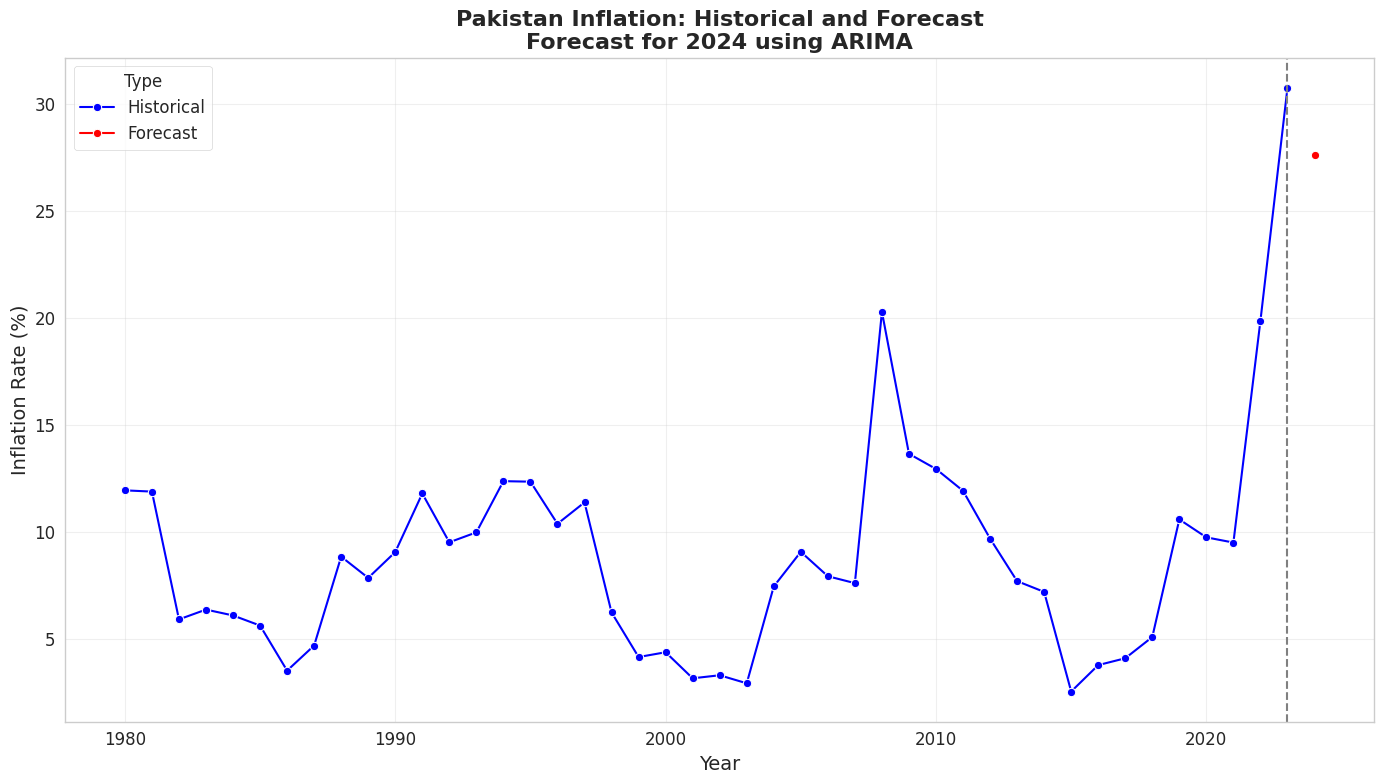

In [26]:
# Use the best model to forecast one year ahead
print(f"\nForecasting future inflation using the best model: {best_model}")
last_year = data['Year'].max()
next_year = last_year + 1
# Create a function for forecasting
def forecast_next_year(best_model_name):
    if best_model_name == 'ARIMA':
        # Fit ARIMA on full data
        final_arima = ARIMA(data['Inflation'].values, order=best_order, trend=best_trend).fit()
        next_forecast = final_arima.forecast(steps=1)
        forecast_value = next_forecast[0]
        return forecast_value, final_arima
    else:
        # Prepare latest data for regression models
        latest_data = data.iloc[-1][['MoneyGrowth', 'FoodImports', 'GDPgrowth', 'ExchangeRate', 'CrudeOil']]
        latest_X = scaler.transform(latest_data.values.reshape(1, -1))

        # Use the appropriate model
        if best_model_name == 'Ridge':
            final_model = ridge_model
        elif best_model_name == 'LASSO':
            final_model = lasso_model
        else:  # Elastic Net
            final_model = elastic_model

        forecast_value = final_model.predict(latest_X)[0]
        return forecast_value, final_model
# Generate forecast
forecast_value, final_model = forecast_next_year(best_model)
print(f"Forecasted inflation for year {next_year}: {forecast_value:.2f}%")
# Plot historical and forecasted inflation
forecast_df = pd.DataFrame({
    'Year': list(data['Year']) + [next_year],
    'Inflation': list(data['Inflation']) + [forecast_value],
    'Type': ['Historical'] * len(data) + ['Forecast']
})
plt.figure(figsize=(14, 8))
sns.lineplot(x='Year', y='Inflation', hue='Type', data=forecast_df, marker='o',
             palette={'Historical': 'blue', 'Forecast': 'red'})
plt.axvline(x=last_year, linestyle='--', color='gray')
plt.title(f'Pakistan Inflation: Historical and Forecast\nForecast for {next_year} using {best_model}',
          fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Inflation Rate (%)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('inflation_forecast.png', dpi=300)
plt.show()

# **CONCLUSIONS AND RECOMMENDATIONS**

In [28]:
print(f"1. Analysis covered Pakistani inflation data from {data['Year'].min()} to {data['Year'].max()}")
print(f"2. Best performing model: {best_model} with Test MSE of {mse_table.loc[mse_table['Model'] == best_model, 'MSE_Test'].values[0]}")
# Give insights based on variable importance if applicable
if best_model != "ARIMA":
    # Get variable importance for the best model
    if best_model == "Ridge":
        best_importance = importance_df[['Variable', 'Ridge']]
    elif best_model == "LASSO":
        best_importance = importance_df[['Variable', 'LASSO']]
    else:
        best_importance = importance_df[['Variable', 'ElasticNet']]

    best_importance = best_importance.sort_values(by=best_importance.columns[1], ascending=False)

    print(f"3. Key inflation drivers according to {best_model} model:")
    for i, row in best_importance.iterrows():
        if not np.isnan(row[1]):
            print(f"   - {row['Variable']}: {row[1]:.2f}%")

print(f"4. Inflation forecast for {next_year}: {forecast_value:.2f}%")
print("\nAnalysis completed and results saved.")

1. Analysis covered Pakistani inflation data from 1980 to 2023
2. Best performing model: ARIMA with Test MSE of 77.7512
4. Inflation forecast for 2024: 27.62%

Analysis completed and results saved.
